In [38]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    //To build sigma2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // To build P_zero of dirchlet process
    vector[P+1] mu_0;
    matrix[P+1,P+1] Sigma_0;
    
    //to build alpha of dp
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    int<lower=1> ngrid;
    vector[ngrid] xgrid;
    
}
parameters{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    matrix[P+1,H] betas;
    vector<lower=0,upper=1>[H-1] vs;       // to build mixture Dirichlet process
}
transformed parameters
{
    simplex[H] omegas;    // wights of sbc
    
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
}

model
{
    alpha ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    vs ~ beta(1,alpha);
    
    for (h in 1:H)
        betas[1:(P+1),h] ~ multi_normal(mu_0, Sigma_0);
        
    for (i in 1:I) {
    
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + normal_lpdf(y[(T*(i-1)+1):i*T] | X[(T*(i-1)+1):(i*T), 1:(P+1)]*betas[1:(P+1),h] , sigma2);
        
        target += log_sum_exp(log_probs);
    }
}
generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + 
            normal_lpdf(y[(T*(i-1)+1):(i*T)] | X[(T*(i-1)+1):(i*T), 1:(P+1)]*betas[1:(P+1),h], sigma2);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    // log_likelihood for each time series
    vector[I] log_lik;
    for (i in 1:I)
      log_lik[i] = log_sum_exp(log_probs[i,1:H]);
    
            
}
"""

stan_file = "SimpleModel_NoRandomEffect.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)



09:07:49 - cmdstanpy - INFO - compiling stan file /home/riccardo/bayesian-project/SimpleModel_NoRandomEffect.stan to exe file /home/riccardo/bayesian-project/SimpleModel_NoRandomEffect
09:08:57 - cmdstanpy - INFO - compiled model executable: /home/riccardo/bayesian-project/SimpleModel_NoRandomEffect


[[1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1.
  1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
  1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.
  0. 1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1.
  1. 0. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1.
  1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.
  1. 1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
  0. 0. 0. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 

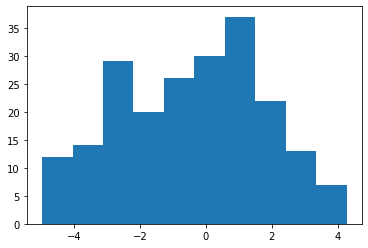

In [39]:
seed = 42
np.random.seed(seed)
I = 30
T = 7
P = 3
nclus = 5
means = np.linspace(-3,3,nclus)
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal allocation 
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(nclus), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    y[T*(i-1):T*i] = np.random.normal(loc=means[true_clus],size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly

mu_0 = np.zeros(P+1) #as in the paper

mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
print(W_raw)

Sigma_0 = np.eye(P+1) #covariance matrix

xgrid_col = np.linspace(-4,4,30)

data = {
    "I": I,
    "T": T,
    "P": P,
    "H": 10,
    "y": y,
    "X": X,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "ngrid": len(xgrid_col),
    "xgrid": xgrid_col
}

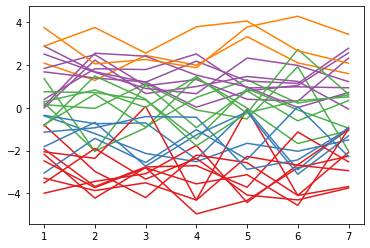

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import matplotlib.colors as colors
 
# create dataframe
fig=plt.axes()
cNorm = colors.Normalize(vmin=0, vmax=9)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap='Set1')
for i in range(1,I+1):
    dataframe = pd.DataFrame({'date_of_week': np.array(range(1,T+1)),
                                  'classes': y[T*(i-1):T*i]})
    fig.plot(dataframe.date_of_week, dataframe.classes, c=scalarMap.to_rgba(true_clus_allocs[i-1]))
    
plt.show()

In [142]:
true_clus_allocs

array([3., 4., 2., 1., 0., 3., 3., 2., 3., 2., 3., 2., 3., 0., 2., 0., 1.,
       0., 1., 1., 3., 0., 4., 0., 2., 2., 4., 0., 1., 0.])

In [43]:
fit = dp_mix.sample(data,
                   iter_warmup = 4000,
                   iter_sampling = 4000)

09:16:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:21:53 - cmdstanpy - INFO - CmdStan done processing.
09:21:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/riccardo/bayesian-project/SimpleModel_NoRandomEffect.stan', line 48, column 4 to column 35)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/riccardo/bayesian-project/SimpleModel_NoRandomEffect.stan', line 48, column 4 to column 35)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/riccardo/bayesian-project/SimpleModel_NoRandomEffect.stan', line 48, column 4 to column 35)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/riccardo/bayesian-project/SimpleModel_NoRandomEffect.stan', line 48, column 4 to column 35)
Consider re-running with show_console=True if the above output is unclear!


In [19]:
fit = az.from_cmdstanpy(fit)

In [20]:
betas = fit.posterior.betas.values
betas.shape 


(4, 1000, 4, 10)

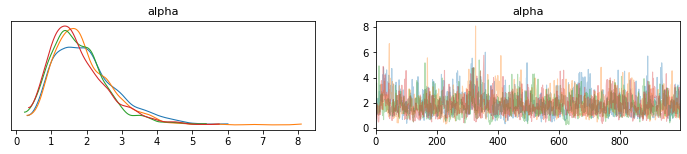

In [21]:
az.plot_trace(fit, var_names=["alpha"], compact=False)
plt.show()

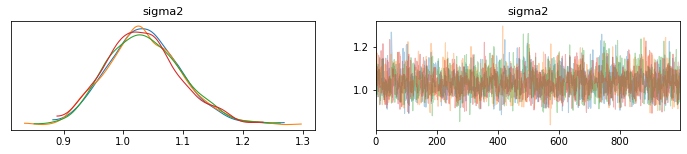

In [22]:
az.plot_trace(fit, var_names=["sigma2"], compact=False)
plt.show()

s
[3. 3. 2. 6. 1. 3. 3. 2. 3. 2. 3. 2. 3. 1. 2. 1. 6. 1. 6. 6. 3. 1. 5. 1.
 2. 2. 5. 1. 6. 1.]
true clusters
[3. 4. 2. 1. 0. 3. 3. 2. 3. 2. 3. 2. 3. 0. 2. 0. 1. 0. 1. 1. 3. 0. 4. 0.
 2. 2. 4. 0. 1. 0.]


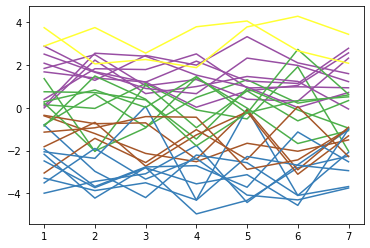

In [23]:
clus =  np.array(fit.posterior.s.values[0, -1, :])
print('s')
print(clus)
print('true clusters')
print(true_clus_allocs)


import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import matplotlib.colors as colors
 
# create dataframe
fig=plt.axes()
cNorm = colors.Normalize(vmin=0, vmax=9)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap='Set1')
for i in range(1,I+1):
    dataframe = pd.DataFrame({'date_of_week': np.array(range(1,T+1)),
                                  'classes': y[T*(i-1):T*i]})
    fig.plot(dataframe.date_of_week, dataframe.classes, c=scalarMap.to_rgba(clus[i-1]))
    
plt.show()

/home/riccardo/.local/lib/python3.9/site-packages/arviz/plots/traceplot.py:215: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


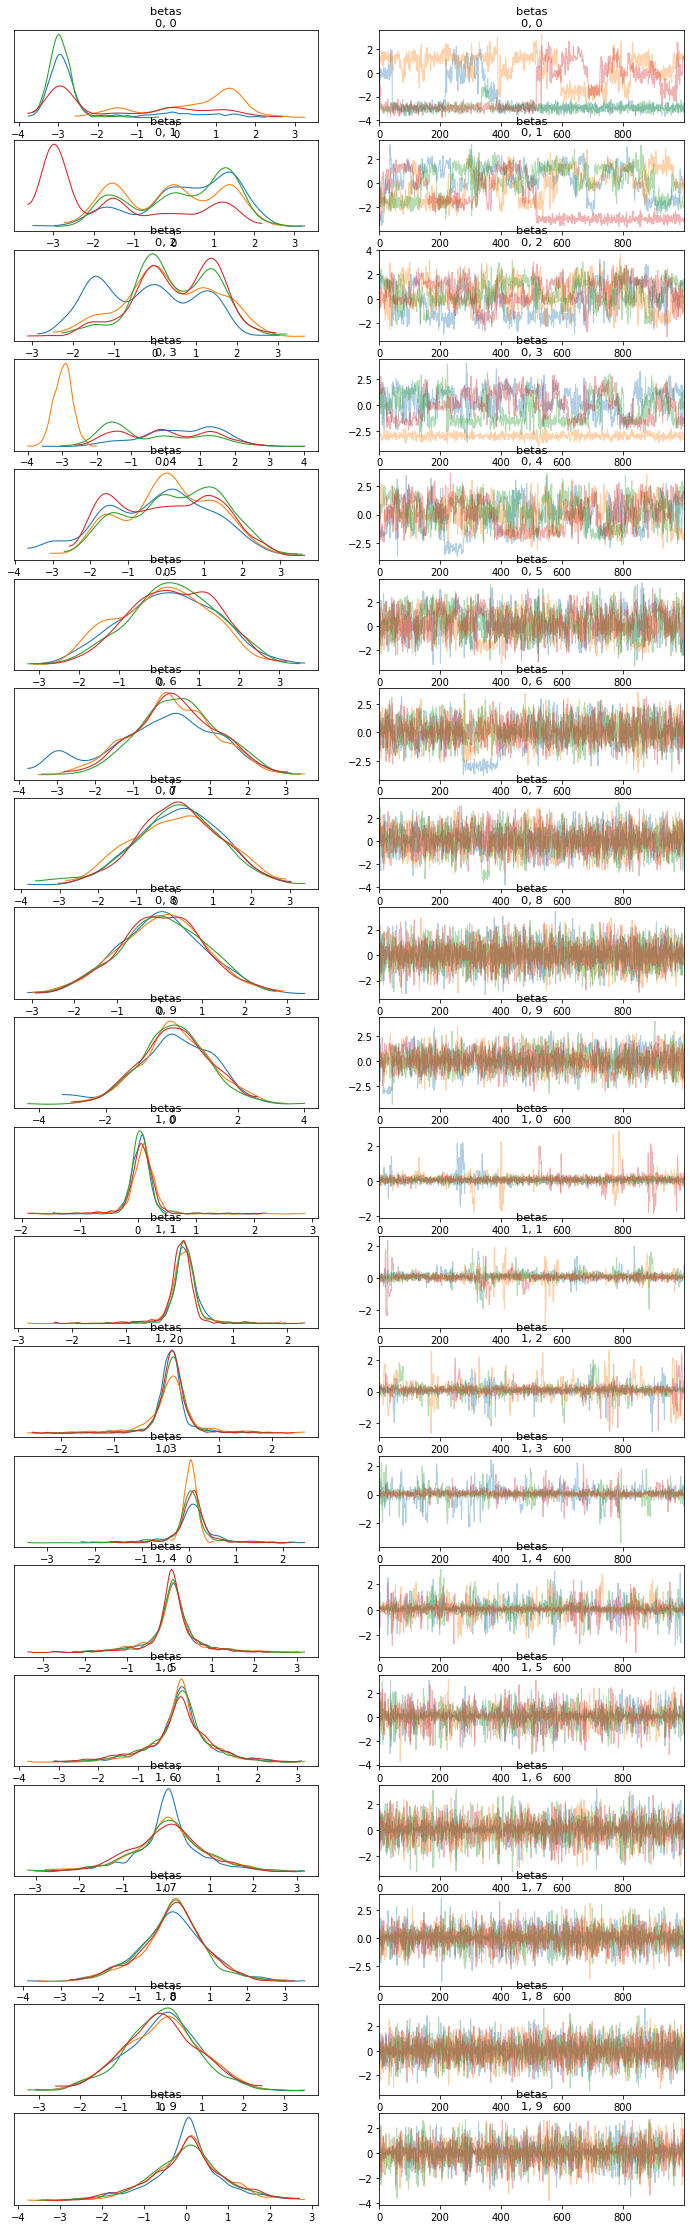

In [24]:
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()

In [44]:
# posterior credible interval of beta
hdis = az.hdi(fit, var_names=["betas"]).betas.values
hdis

# hdi_prob=.68 for specifying alpha
# understanding multimodality 

array([[[-3.29766 ,  1.87322 ],
        [-3.3792  ,  1.83105 ],
        [-3.33374 ,  1.82363 ],
        [-3.30587 ,  1.9162  ],
        [-2.1794  ,  2.35793 ],
        [-2.331   ,  2.58333 ],
        [-2.19468 ,  2.32888 ],
        [-1.87174 ,  2.13787 ],
        [-1.91576 ,  1.95181 ],
        [-2.36384 ,  2.53389 ]],

       [[-0.485562,  0.635133],
        [-0.519716,  0.675215],
        [-0.735295,  0.808323],
        [-0.888564,  0.976943],
        [-1.24631 ,  1.29915 ],
        [-1.53144 ,  1.46052 ],
        [-1.62659 ,  1.69542 ],
        [-1.74441 ,  1.81733 ],
        [-1.77683 ,  1.8097  ],
        [-1.69739 ,  1.62774 ]],

       [[-0.646166,  0.654729],
        [-0.650026,  0.712826],
        [-0.808483,  0.812629],
        [-0.929148,  1.07249 ],
        [-1.28069 ,  1.33693 ],
        [-1.56152 ,  1.54885 ],
        [-1.68712 ,  1.70958 ],
        [-1.7434  ,  1.87017 ],
        [-1.78433 ,  1.81653 ],
        [-1.63086 ,  1.84528 ]],

       [[-0.446936,  0.904914],
  

In [45]:
az.waic(fit)

/home/riccardo/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 16000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -363.48     6.97
p_waic       22.06        -

There has been a warning during the calculation. Please check the results.

In [47]:
#Estimates the expected log pointwise predictive density (elpd) using Pareto-smoothed importance sampling 
# leave-one-out cross-validation (PSIS-LOO-CV).
az.loo(fit)

/home/riccardo/.local/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 16000 posterior samples and 30 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -364.73     7.12
p_loo       23.32        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       23   76.7%
 (0.5, 0.7]   (ok)          6   20.0%
   (0.7, 1]   (bad)         1    3.3%
   (1, Inf)   (very bad)    0    0.0%